In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')
import json # will be needed for saving preprocessing details
from sklearn.preprocessing import LabelEncoder # for preprocessing
import joblib # for saving algorithm and preprocessing objects


pd.set_option('display.max_columns', 30)
df=pd.read_csv("kc_house_data_clean.csv")


## Test sur modèle naif : régression linéaire

In [25]:
Xn=df.drop("price", axis=1)
yn=df["price"]
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.2, random_state=42)

modele_naif_reg_lin = linear_model.LinearRegression()
modele_naif_reg_lin.fit(Xn_train, yn_train )

print("Score modèle naif reg linéaire :", modele_naif_reg_lin.score(Xn_test, yn_test))

# Score modèle naif reg linéaire ridge : 0.6979840506422199


Score modèle naif reg linéaire : 0.6979840506422199


In [26]:
df_score=pd.DataFrame(columns = ["knn", "lasso", "ridge"])

## Comparaison des modèles de régression linéaires et knn

In [27]:
modele_naif_lasso = linear_model.Lasso(alpha=1)
modele_naif_lasso.fit(Xn_train, yn_train )

modele_naif_ridge = linear_model.Ridge(alpha=1)
modele_naif_ridge.fit(Xn_train, yn_train )

knn_naif = KNeighborsRegressor(n_neighbors=15)
knn_naif.fit(Xn_train, yn_train )

# scoring sur X_test
df_score.loc[0, "knn"] = knn_naif.score(Xn_test, yn_test)
df_score.loc[0, "lasso"] = modele_naif_lasso.score(Xn_test, yn_test)
df_score.loc[0, "ridge"] = modele_naif_ridge.score(Xn_test, yn_test)

print(df_score)


        knn     lasso     ridge
0  0.511373  0.697985  0.698023


## Choix des meilleurs hyperparamètres

In [28]:
from sklearn.model_selection import train_test_split
y = df['price']
X = df.drop('price', axis=1).drop('sqft_living15', axis=1).drop('sqft_lot15', axis=1)
# X = df.drop('sqft_living15', axis = 1)
# X =df.drop('sqft_lot15', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

from sklearn.model_selection import GridSearchCV

#################### KNN #####################################################################################
algorithm = KNeighborsRegressor()

# Définir une grille de paramètres
hp_candidates = [{'n_neighbors': range(20), 'weights': ['uniform','distance']}]

# Effectuer une recherche aléatoire sur les hyperparamètres
# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=5, scoring='r2')
grid.fit(X, y)

best_param_knn = grid.best_params_
# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(best_param_knn)

################################ LASSO ###################################################################################
algorithm = linear_model.Lasso()

# Définir une grille de paramètres
hp_candidates = [{'alpha': range(20)}]

# Effectuer une recherche aléatoire sur les hyperparamètres
# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=5, scoring='r2')
grid.fit(X, y)

best_param_lasso = grid.best_params_
# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(best_param_lasso)

############################### RIDGE  ######################################################################################
algorithm = linear_model.Ridge()

# Définir une grille de paramètres
hp_candidates = [{'alpha': range(20)}]

# Effectuer une recherche aléatoire sur les hyperparamètres
# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=5, scoring='r2')
grid.fit(X, y)

best_param_ridge = grid.best_params_
# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(best_param_ridge)



0.529476608466635
KNeighborsRegressor(n_neighbors=13, weights='distance')
{'n_neighbors': 13, 'weights': 'distance'}
0.6949046197781066
Lasso(alpha=19)
{'alpha': 19}
0.6949133160021772
Ridge(alpha=3)
{'alpha': 3}


## Création des pipelines

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

    imputer: cette étape utilise la classe SimpleImputer de Scikit-learn pour remplacer les valeurs manquantes dans les données numériques par la moyenne des valeurs présentes dans la colonne correspondante. La stratégie utilisée est "mean", ce qui signifie que la moyenne des valeurs non manquantes dans la colonne est utilisée pour remplacer les valeurs manquantes.

    stdscaler: cette étape utilise la classe MinMaxScaler de Scikit-learn pour normaliser les données numériques. La normalisation est effectuée de manière à ce que toutes les valeurs soient ramenées dans la plage [0, 1]. Cette étape est souvent utilisée pour améliorer la stabilité des algorithmes d'apprentissage automatique, tels que la régression, le SVM ou l'ACP.

### Preprocessing 1 : SimpleImputer, MinMaxScaler, OneHotEncoder

#### Pipelines d'entrainement

In [30]:
#Pipeline de préprocessing pour les variables numériques
numeric_features = ["sqft_living","sqft_above", "sqft_basement", "sqft_lot", "bathrooms"]

numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('stdscaler', MinMaxScaler()),  # moyenne nulle et écart type = 1 -> Reg, SVM, PCA
        ])

# Pipeline de pre-processing pour les variables catégorielles
categorial_features = [ "zipcode", "floors", "view", "condition", "grade", "bedrooms"]

categorical_transformer = OneHotEncoder(sparse=True, handle_unknown='ignore')

# a l'aide de la classe ColumnTransformer, 
# on déclare à quelles variables on applique quel transformer
from sklearn.compose import ColumnTransformer
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ], remainder="passthrough"
)


#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
knn_1 = KNeighborsRegressor(**best_param_knn)
lasso_1 = linear_model.Lasso(**best_param_lasso)
ridge_1 = linear_model.Ridge(**best_param_ridge)

pipe_knn_1 = Pipeline([
     ('prep', preprocessor_1),
     ('knn', knn_1)
])

pipe_lasso_1 = Pipeline([
     ('prep', preprocessor_1),
     ('lasso', lasso_1)
])

pipe_ridge_1 = Pipeline([
     ('prep', preprocessor_1),
     ('ridge', ridge_1)
])

#### Entrainement 

In [31]:
# Entrainement sur X_train
trained_pipe_knn_1 = pipe_knn_1.fit(X_train,y_train)
trained_pipe_lasso_1 = pipe_lasso_1.fit(X_train,y_train)
trained_pipe_ridge_1 = pipe_ridge_1.fit(X_train,y_train)

#### Score

In [32]:
# scoring sur X_test
df_score.loc[1, "knn"] = trained_pipe_knn_1.score(X_test, y_test)
df_score.loc[1, "lasso"] = trained_pipe_lasso_1.score(X_test, y_test)
df_score.loc[1, "ridge"] = trained_pipe_ridge_1.score(X_test, y_test)

print(df_score)

        knn     lasso     ridge
0  0.511373  0.697985  0.698023
1  0.537581  0.841808  0.835541


### Preprocessing 2 : OneHotEncoder only

In [33]:
#Pipeline de préprocessing pour les variables catégorielles

categorial_features = [ "zipcode", "floors", "view", "condition", "grade", "bedrooms"]

categorical_transformer = OneHotEncoder(sparse=True, handle_unknown='ignore')

# a l'aide de la classe ColumnTransformer, 
# on déclare à quelles variables on applique quel transformer
from sklearn.compose import ColumnTransformer
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features)
    ], remainder="passthrough"
)


#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
knn_2 = KNeighborsRegressor(**best_param_knn)
lasso_2 = linear_model.Lasso(**best_param_lasso)
ridge_2 = linear_model.Ridge(**best_param_ridge)

pipe_knn_2 = Pipeline([
     ('prep', preprocessor_2),
     ('knn', knn_2)
])

pipe_lasso_2 = Pipeline([
     ('prep', preprocessor_2),
     ('lasso', lasso_2)
])

pipe_ridge_2 = Pipeline([
     ('prep', preprocessor_2),
     ('ridge', ridge_2)
])

# Entrainement sur X_train
trained_pipe_knn_2 = pipe_knn_2.fit(X_train,y_train)
trained_pipe_lasso_2 = pipe_lasso_2.fit(X_train,y_train)
trained_pipe_ridge_2 = pipe_ridge_2.fit(X_train,y_train)

#Prediction sur X_test :
y_pred_lasso_2 = trained_pipe_lasso_2.predict(X_test)


# scoring sur X_test
df_score.loc[2, "knn"] = trained_pipe_knn_2.score(X_test, y_test)
df_score.loc[2, "lasso"] = trained_pipe_lasso_2.score(X_test, y_test)
df_score.loc[2, "ridge"] = trained_pipe_ridge_2.score(X_test, y_test)

print(df_score)

        knn     lasso     ridge
0  0.511373  0.697985  0.698023
1  0.537581  0.841808  0.835541
2  0.541929  0.841811  0.537308


### Préprocessing 3 : SimpleImputer, MinMaxScaler, OneHotEncoder, VE bed remplacé par un max

In [34]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Transformer pour remplacer les valeurs extrêmes de la colonne "bedrooms" par une valeur max
max_value = 11.0 
bedrooms_transformer = Pipeline([
     ('max_replacer', FunctionTransformer(lambda x: np.where(x > max_value, max_value, x))),
])


#Pipeline de préprocessing pour les variables numériques
numeric_features = ["sqft_living","sqft_above", "sqft_basement", "sqft_lot", "bathrooms"]

numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('stdscaler', MinMaxScaler()),  # moyenne nulle et écart type = 1 -> Reg, SVM, PCA
        ])

#Pipeline de préprocessing pour les variables catégorielles

categorial_features = [ "zipcode", "floors", "view", "condition", "grade", "bedrooms"]

categorical_transformer = OneHotEncoder(sparse=True, handle_unknown='ignore')

# a l'aide de la classe ColumnTransformer, 
# on déclare à quelles variables on applique quel transformer
from sklearn.compose import ColumnTransformer
preprocessor_3 = ColumnTransformer(
    transformers=[
         ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features),
        ('bed', bedrooms_transformer, ['bedrooms']),
    ], remainder="passthrough"
)


#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
knn = KNeighborsRegressor(**best_param_knn)
lasso = linear_model.Lasso(**best_param_lasso)
ridge = linear_model.Ridge(**best_param_ridge)

pipe_knn = Pipeline([
     ('prep', preprocessor_3),
     ('knn', knn)
])

pipe_lasso = Pipeline([
     ('prep', preprocessor_3),
     ('lasso', lasso)
])

pipe_ridge = Pipeline([
     ('prep', preprocessor_3),
     ('ridge', ridge)
])

# Entrainement sur X_train
trained_pipe_knn_3 = pipe_knn.fit(X_train,y_train)
trained_pipe_lasso_3 = pipe_lasso.fit(X_train,y_train)
trained_pipe_ridge_3 = pipe_ridge.fit(X_train,y_train)

# scoring sur X_test
# scoring sur X_test
df_score.loc[3, "knn"] = trained_pipe_knn_3.score(X_test, y_test)
df_score.loc[3, "lasso"] = trained_pipe_lasso_3.score(X_test, y_test)
df_score.loc[3, "ridge"] = trained_pipe_ridge_3.score(X_test, y_test)

print(df_score)

        knn     lasso     ridge
0  0.511373  0.697985  0.698023
1  0.537581  0.841808  0.835541
2  0.541929  0.841811  0.537308
3  0.514192  0.841818  0.836475


### Preprocessing 4 

In [35]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Transformer pour remplacer les valeurs extrêmes de la colonne "bedrooms" par une valeur max
max_value = 11.0 
bedrooms_transformer = Pipeline([
     ('max_replacer', FunctionTransformer(lambda x: np.where(x > max_value, max_value, x))),
])

# Transformer pour remplacer les valeurs extrêmes de la colonne "sqft_living" par une valeur max
max_value = 12500
sqft_living_transformer = Pipeline([
     ('max_replacer', FunctionTransformer(lambda x: np.where(x > max_value, max_value, x))),
])



#Pipeline de préprocessing pour les variables numériques
numeric_features = ["sqft_living","sqft_above", "sqft_basement", "sqft_lot", "bathrooms"]

numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('stdscaler', MinMaxScaler()),  # moyenne nulle et écart type = 1 -> Reg, SVM, PCA
        ])

#Pipeline de préprocessing pour les variables catégorielles

categorial_features = [ "zipcode", "floors", "view", "condition", "grade", "bedrooms"]

categorical_transformer = OneHotEncoder(sparse=True, handle_unknown='ignore')

# a l'aide de la classe ColumnTransformer, 
# on déclare à quelles variables on applique quel transformer
from sklearn.compose import ColumnTransformer
preprocessor_4 = ColumnTransformer(
    transformers=[
         ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features),
        ('bed', bedrooms_transformer, ['bedrooms']),
        ('living', sqft_living_transformer, ['sqft_living']),
    ], remainder="passthrough"
)


#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
knn = KNeighborsRegressor(**best_param_knn)
lasso = linear_model.Lasso(**best_param_lasso)
ridge = linear_model.Ridge(**best_param_ridge)

pipe_knn = Pipeline([
     ('prep', preprocessor_4),
     ('knn', knn)
])

pipe_lasso = Pipeline([
     ('prep', preprocessor_4),
     ('lasso', lasso)
])

pipe_ridge = Pipeline([
     ('prep', preprocessor_4),
     ('ridge', ridge)
])

# Entrainement sur X_train
trained_pipe_knn_4 = pipe_knn.fit(X_train,y_train)
trained_pipe_lasso_4 = pipe_lasso.fit(X_train,y_train)
trained_pipe_ridge_4 = pipe_ridge.fit(X_train,y_train)

# scoring sur X_test
# scoring sur X_test
df_score.loc[4, "knn"] = trained_pipe_knn_4.score(X_test, y_test)
df_score.loc[4, "lasso"] = trained_pipe_lasso_4.score(X_test, y_test)
df_score.loc[4, "ridge"] = trained_pipe_ridge_4.score(X_test, y_test)

print(df_score)

        knn     lasso     ridge
0  0.511373  0.697985  0.698023
1  0.537581  0.841808  0.835541
2  0.541929  0.841811  0.537308
3  0.514192  0.841818  0.836475
4  0.565551  0.841803  0.752097


### Preprocessing 5

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import numpy as np

# Transformer pour remplacer les valeurs extrêmes de la colonne "bedrooms" par une valeur max
max_value = 11.0 
bedrooms_transformer = Pipeline([
     ('max_replacer', FunctionTransformer(lambda x: np.where(x > max_value, max_value, x))),
])

# Pipeline de préprocessing pour les variables numériques
numeric_features = ["sqft_living","sqft_above", "sqft_basement", "sqft_lot", "bathrooms"]
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', MinMaxScaler()),  
])

# Pipeline de préprocessing pour les variables catégorielles
categorial_features = ["zipcode", "floors", "view", "condition", "grade", "bedrooms"]
categorical_transformer = OneHotEncoder(sparse=True, handle_unknown='ignore')

# à l'aide de la classe ColumnTransformer, 
# on déclare à quelles variables on applique quel transformer
preprocessor_5 = ColumnTransformer(
    transformers=[
         ('num', numeric_transformer, numeric_features),
         ('cat', categorical_transformer, categorial_features),
         ('bed', bedrooms_transformer, ['bedrooms']),
    ], 
    remainder="passthrough"
)

# On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entrainement
#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
knn = KNeighborsRegressor(**best_param_knn)
lasso = linear_model.Lasso(**best_param_lasso)
ridge = linear_model.Ridge(**best_param_ridge)

pipe_knn = Pipeline([
     ('prep', preprocessor_5),
     ('knn', knn)
])

pipe_lasso = Pipeline([
     ('prep', preprocessor_5),
     ('lasso', lasso)
])

pipe_ridge = Pipeline([
     ('prep', preprocessor_5),
     ('ridge', ridge)
])

# Entrainement sur X_train
trained_pipe_knn_5 = pipe_knn.fit(X_train,y_train)
trained_pipe_lasso_5 = pipe_lasso.fit(X_train,y_train)
trained_pipe_ridge_5 = pipe_ridge.fit(X_train,y_train)

# scoring sur X_test
# scoring sur X_test
df_score.loc[5, "knn"] = trained_pipe_knn_5.score(X_test, y_test)
df_score.loc[5, "lasso"] = trained_pipe_lasso_5.score(X_test, y_test)
df_score.loc[5, "ridge"] = trained_pipe_ridge_5.score(X_test, y_test)

print(df_score)



        knn     lasso     ridge
0  0.511373  0.697985  0.698023
1  0.537581  0.841808  0.835541
2  0.541929  0.841811  0.537308
3  0.514192  0.841818  0.836475
4  0.565551  0.841803  0.752097
5  0.514192  0.841818  0.836475


### Preprocessing 6 : 2 + polynomial features

In [37]:
poly = PolynomialFeatures(2)

#Pipeline de préprocessing pour les variables catégorielles

categorial_features = [ "zipcode", "floors", "view", "condition", "grade", "bedrooms"]

categorical_transformer = OneHotEncoder(sparse=True, handle_unknown='ignore')

# a l'aide de la classe ColumnTransformer, 
# on déclare à quelles variables on applique quel transformer
from sklearn.compose import ColumnTransformer
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features)
    ], remainder="passthrough"
)


#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
knn_6 = KNeighborsRegressor(**best_param_knn)
lasso_6 = linear_model.Lasso(**best_param_lasso)
ridge_6 = linear_model.Ridge(**best_param_ridge)

pipe_knn_6 = Pipeline([
     ('prep', preprocessor_2),
     ('poly', poly),
     ('knn', knn_2)
])

pipe_lasso_6 = Pipeline([
     ('prep', preprocessor_2),
     ('poly', poly),
     ('lasso', lasso_6)
])

pipe_ridge_6 = Pipeline([
     ('prep', preprocessor_2),
     ('poly', poly),
     ('ridge', ridge_6)
])

# Entrainement sur X_train
trained_pipe_knn_6 = pipe_knn_6.fit(X_train,y_train)
trained_pipe_lasso_6 = pipe_lasso_6.fit(X_train,y_train)
trained_pipe_ridge_6 = pipe_ridge_6.fit(X_train,y_train)

#Prediction sur X_test :
y_pred_lasso_6 = trained_pipe_lasso_6.predict(X_test)


# scoring sur X_test
df_score.loc[6, "knn"] = trained_pipe_knn_6.score(X_test, y_test)
df_score.loc[6, "lasso"] = trained_pipe_lasso_6.score(X_test, y_test)
df_score.loc[6, "ridge"] = trained_pipe_ridge_6.score(X_test, y_test)

print(df_score)

        knn     lasso     ridge
0  0.511373  0.697985  0.698023
1  0.537581  0.841808  0.835541
2  0.541929  0.841811  0.537308
3  0.514192  0.841818  0.836475
4  0.565551  0.841803  0.752097
5  0.514192  0.841818  0.836475
6     0.511  0.879376  0.573734


### Préprocessing 7 : 5 + polynomial features

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import numpy as np

poly = PolynomialFeatures(2)

# Transformer pour remplacer les valeurs extrêmes de la colonne "bedrooms" par une valeur max
max_value = 11.0 
bedrooms_transformer = Pipeline([
     ('max_replacer', FunctionTransformer(lambda x: np.where(x > max_value, max_value, x))),
])

# Pipeline de préprocessing pour les variables numériques
numeric_features = ["sqft_living","sqft_above", "sqft_basement", "sqft_lot", "bathrooms"]
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', MinMaxScaler()),  
])

# Pipeline de préprocessing pour les variables catégorielles
categorial_features = ["zipcode", "floors", "view", "condition", "grade", "bedrooms"]
categorical_transformer = OneHotEncoder(sparse=True, handle_unknown='ignore')

# à l'aide de la classe ColumnTransformer, 
# on déclare à quelles variables on applique quel transformer
preprocessor_5 = ColumnTransformer(
    transformers=[
         ('num', numeric_transformer, numeric_features),
         ('cat', categorical_transformer, categorial_features),
         ('bed', bedrooms_transformer, ['bedrooms']),
    ], 
    remainder="passthrough"
)

# On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entrainement
#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
knn = KNeighborsRegressor(**best_param_knn)
lasso = linear_model.Lasso(**best_param_lasso)
ridge = linear_model.Ridge(**best_param_ridge)

pipe_knn = Pipeline([
     ('prep', preprocessor_5),
     ('poly', poly),
     ('knn', knn)
])

pipe_lasso = Pipeline([
     ('prep', preprocessor_5),
     ('poly', poly),
     ('lasso', lasso)
])

pipe_ridge = Pipeline([
     ('prep', preprocessor_5),
     ('poly', poly),
     ('ridge', ridge)
])

# Entrainement sur X_train
trained_pipe_knn_7 = pipe_knn.fit(X_train,y_train)
trained_pipe_lasso_7 = pipe_lasso.fit(X_train,y_train)
trained_pipe_ridge_7 = pipe_ridge.fit(X_train,y_train)

# scoring sur X_test
# scoring sur X_test
df_score.loc[7, "knn"] = trained_pipe_knn_7.score(X_test, y_test)
df_score.loc[7, "lasso"] = trained_pipe_lasso_7.score(X_test, y_test)
df_score.loc[7, "ridge"] = trained_pipe_ridge_7.score(X_test, y_test)

print(df_score)

        knn     lasso     ridge
0  0.511373  0.697985  0.698023
1  0.537581  0.841808  0.835541
2  0.541929  0.841811  0.537308
3  0.514192  0.841818  0.836475
4  0.565551  0.841803  0.752097
5  0.514192  0.841818  0.836475
6     0.511  0.879376  0.573734
7  0.461902  0.867943  0.839491


### Résultats

In [39]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: greenyellow' if v else '' for v in is_max]

# Définir une fonction pour mettre en valeur la cellule maximale
def highlight_max_max(val):
    return 'background-color: limegreen' if val == max_value else ''

# Trouver la valeur maximale pour tout le DataFrame
max_value = df_score.values.max()

# Appliquer les deux fonctions au DataFrame
styled_df = df_score.style.format("{:.8f}").apply(highlight_max).applymap(highlight_max_max)

# Afficher le DataFrame mis en forme
display(styled_df)

## Result
#  	knn	lasso	ridge
# 0	0.51137255	0.69798473	0.69802278
# 1	0.53758146	0.84180780	0.83554070
# 2	0.54192935	0.84181092	0.53730847
# 3	0.51419181	0.84181804	0.83647485
# 4	0.56555132	0.84180317	0.75209657
# 5	0.51419181	0.84181804	0.83647485
# 6	0.51100047	0.87937633	0.57373429
# 7	0.46190184	0.86794255	0.83949081

,knn,lasso,ridge
0,0.51137255,0.69798473,0.69802278
1,0.53758146,0.84180780,0.83554070
2,0.54192935,0.84181092,0.53730847
3,0.51419181,0.84181804,0.83647485
4,0.56555132,0.84180317,0.75209657
5,0.51419181,0.84181804,0.83647485
6,0.51100047,0.87937633,0.57373429
7,0.46190184,0.86794255,0.83949081


In [ ]:
## En conservant sqft_leaving15 et sqft_lot15 :
#  	    knn	       lasso	  ridge
# 0	0.51137255	0.69798473	0.69802278
# 1	0.38188135	0.84196238	0.36449355
# 2	0.52267104	0.84197975	0.54692338
# 3	0.38209044	0.84197613	0.36450665
# 4	0.56622749	0.84196596	0.54654374
# 5	0.38209044	0.84197613	0.36450665
# 6	0.47502985	0.87321436	0.58771407
# 7	0.36870335	0.88325673	0.36938396

In [42]:
joblib.dump(trained_pipe_lasso_6, "./../saved_models/trained_pipe_bis.joblib", compress=True)

['./../saved_models/trained_pipe_bis.joblib']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


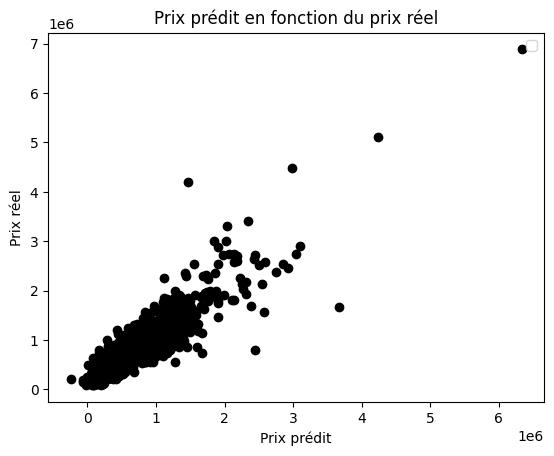

In [46]:
import matplotlib.pyplot as plt

# Prédiction des prix pour les données de test
y_pred = trained_pipe_lasso_7.predict(X_test)

# Tracé du graphique
plt.scatter(y_pred, y_test, color='black')

plt.title("Prix prédit en fonction du prix réel")
plt.xlabel("Prix prédit")
plt.ylabel("Prix réel")
plt.legend()
